In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
#from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split




In [2]:
import os, shutil

# Uncomment the following line to mount the google drive
#from google.colab import drive
#drive.mount('/content/drive')
#data_dir = '/content/drive/MyDrive/ML3/Final Project/CV2/data/'

# Set the data directory for local use.
data_dir = 'data/' #  Ensure SMNIST csv is in this directory
model_dir = 'models/' # Directory to save models
plot_dir = 'plots/' # Directory to save plots

In [3]:
train_df = pd.read_csv(data_dir + "sign_mnist_train.csv")
test_df = pd.read_csv(data_dir + "sign_mnist_test.csv")

y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.fit_transform(y_test)


In [4]:
x_train = train_df.values
x_test = test_df.values

x_train = x_train / 255
x_test = x_test / 255

x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

## import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=0.25):
    epsilon = tf.keras.backend.epsilon()
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
    p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
    fl = -alpha_t * tf.keras.backend.pow((1 - p_t), gamma) * tf.keras.backend.log(p_t)
    return tf.keras.backend.mean(tf.keras.backend.sum(fl, axis=-1))

@tf.keras.utils.register_keras_serializable()
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        return focal_loss_fixed(y_true, y_pred, gamma, alpha)
    return loss

# Load and preprocess dataset
train_df = pd.read_csv(data_dir + "sign_mnist_train.csv")
test_df = pd.read_csv(data_dir + "sign_mnist_test.csv")

y_train = train_df['label']
y_test = test_df['label']
del train_df['label']
del test_df['label']

label_binarizer = LabelBinarizer()
y_train = label_binarizer.fit_transform(y_train)
y_test = label_binarizer.transform(y_test)  # Use transform instead of fit_transform

x_train = train_df.values / 255.0
x_test = test_df.values / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(x_train)

# Model architecture
num_classes = y_train.shape[1]
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with focal loss
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

# Class weights to handle class imbalance
class_weights = {i: 1.0 for i in range(num_classes)}
class_weights[12] = 2.0  # Adjust for 'm' (assuming class index 12)
class_weights[13] = 2.0  # Adjust for 'n' (assuming class index 13)

# Train the model
checkpoint = ModelCheckpoint(model_dir + 'smnist.cnn-32.64.128.512-50e.best.keras', monitor='val_loss', save_best_only=True)
start_time = time.time()
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                    epochs=50,
                    validation_data=(x_test, y_test),
                    class_weight=class_weights,
                    callbacks=checkpoint)
end_time = time.time()

training_time = end_time - start_time

model.save(model_dir + 'smnist.cnn-32.64.128.512-50e.last.keras')

model.summary()

# Evaluate and visualize confusion matrix
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [6]:
# Assuming num_classes is 24
num_classes = 24
# y_true_classes and y_pred_classes are your true and predicted class labels

# Create the list of target names, excluding 'J' and 'Z'
target_names = [chr(i) for i in range(65, 65 + 26) if chr(i) not in ['J', 'Z']]

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

           A       0.98      1.00      0.99       331
           B       1.00      1.00      1.00       432
           C       1.00      1.00      1.00       310
           D       1.00      1.00      1.00       245
           E       0.99      1.00      1.00       498
           F       1.00      1.00      1.00       247
           G       1.00      0.99      0.99       348
           H       0.99      1.00      0.99       436
           I       1.00      1.00      1.00       288
           K       1.00      1.00      1.00       331
           L       1.00      1.00      1.00       209
           M       1.00      1.00      1.00       394
           N       1.00      1.00      1.00       291
           O       1.00      1.00      1.00       246
           P       1.00      1.00      1.00       347
           Q       1.00      1.00      1.00       164
           R       0.99      1.00      1.00       144
           S       1.00    

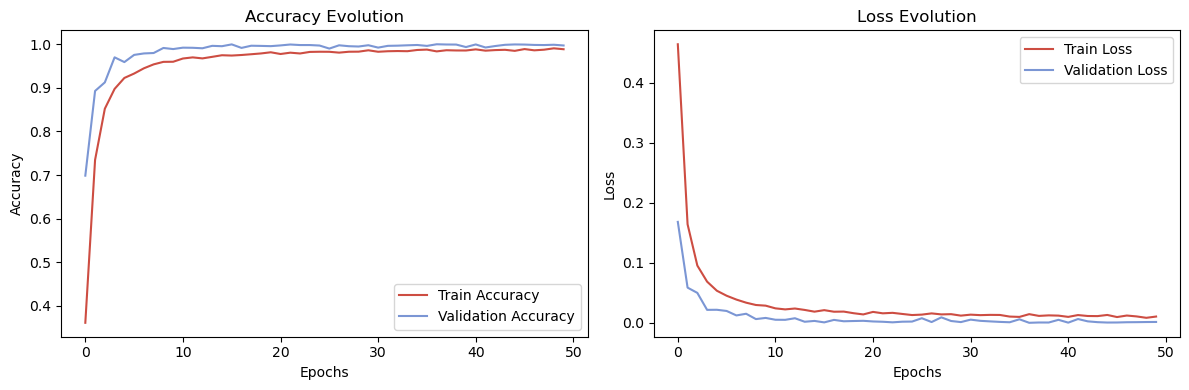

In [7]:
# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='#CD4D42')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#7B96D4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='#CD4D42')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#7B96D4')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

plt.tight_layout()
plt.show()

# CV2 Video Inferencing

# Inferencing App

## Semi works

## Try 10:

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import gradio as gr
from keras.models import load_model

# Load your trained model
#model = load_model('models/smnist.cnn-32.64.128.512-50e.best.keras')


# Load the model with custom objects
custom_objects = {'focal_loss': focal_loss}
loaded_model = tf.keras.models.load_model('models/smnist.cnn-32.64.128.512-50e.best.keras', custom_objects=custom_objects)

def load_video_frame(video_path):
    """Loads the first frame from a video file and converts it to a NumPy array."""
    try:
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            print("Error reading video frame!")
            return None
        return frame
    except Exception as e:
        print(f"Error loading video frame from path: {e}")
        return None

def hand_gesture_recognition(frame):
    """Processes a video frame for hand gesture recognition.

    Args:
        frame: A file path or a NumPy array representing the video frame.

    Returns:
        A tuple containing:
            - predicted_letter (str): The predicted letter or None if no hand is detected.
            - confidence (dict): A dictionary with the predicted letter and confidence score.
            - frame (NumPy array): The original frame with a bounding box around the detected hand (if any).
    """
    print(f"Received frame of type: {type(frame)}")

    if isinstance(frame, str):
        print(f"Frame path: {frame}")
        frame = load_video_frame(frame)

    if frame is None:
        print("Frame is None!")
        return None, {"confidence": 0.0}, frame
    if not isinstance(frame, np.ndarray):
        print("Frame is not a NumPy array!")
        return None, {"confidence": 0.0}, frame
    if frame.size == 0:
        print("Frame size is 0!")
        return None, {"confidence": 0.0}, frame

    print("Processing frame of shape:", frame.shape)

    # MediaPipe hand detection setup
    mphands = mp.solutions.hands
    hands = mphands.Hands()
    mp_drawing = mp.solutions.drawing_utils

    try:
        # Convert BGR frame to RGB for MediaPipe
        framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    except cv2.error as e:
        print("Error converting frame to RGB:", e)
        return None, {"confidence": 0.0}, frame

    # Detect hands in the frame
    result = hands.process(framergb)
    hand_landmarks = result.multi_hand_landmarks

    predicted_letter = None
    confidence = 0.0

    if hand_landmarks:
        # Extract hand region from the frame
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = frame.shape[1]  # Width
            y_min = frame.shape[0]  # Height
            for lm in handLMs.landmark:
                x, y = int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0])
                x_max = max(x_max, x)
                y_max = max(y_max, y)
                x_min = min(x_min, x)
                y_min = min(y_min, y)

            y_min = max(0, y_min - 20)  # Adjust bounding box margin
            y_max = min(frame.shape[0], y_max + 20)
            x_min = max(0, x_min - 20)
            x_max = min(frame.shape[1], x_max + 20)

            hand_region = frame[y_min:y_max, x_min:x_max]

            # Preprocess hand region for model input
            hand_region = cv2.cvtColor(hand_region, cv2.COLOR_BGR2GRAY)
            hand_region = cv2.resize(hand_region, (28, 28))

            hand_region = hand_region.reshape(1, 28, 28, 1)
            hand_region = hand_region.astype('float32') / 255.0

            # Make prediction using the loaded model
            prediction = model.predict(hand_region)
            predarray = np.array(prediction[0])
            letterpred = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
            letter_prediction_dict = {letterpred[i]: predarray[i] for i in range(len(letterpred))}

            # Choose the most confident prediction
            predicted_letter = max(letter_prediction_dict, key=letter_prediction_dict.get)
            confidence = float(letter_prediction_dict[predicted_letter])

            # Draw bounding box around the detected hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green bounding box with thickness 2

    return predicted_letter, {"confidence": confidence}, frame

# Create a Gradio interface
interface = gr.Interface(
    fn=hand_gesture_recognition,
    inputs=gr.Video(label="Webcam"),
    outputs=[gr.Label(label="Predicted Letter"), gr.Label(label="Confidence"), gr.Image(type="numpy")],
    live=True,
    title="Hand Gesture Recognition",
    description="Show your hand and get the predicted letter and confidence score."
)

# Launch the Gradio interface
interface.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/f807ee23c77fa05411900dc732b3414f0a5e84e1/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


I0000 00:00:1717747490.662687  327958 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747490.689497  329032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747490.693212  329032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/richardrian/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/aa91fcd83b742d166f5ff0fc3629e0f8e4df1043/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


I0000 00:00:1717747780.659406  327958 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747780.680223  338635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747780.696541  338635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/d78b2313ec5e6078799c5b12c1c54806e871ba77/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


I0000 00:00:1717747868.518248  327958 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747868.526896  341784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747868.532192  341784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/911909c7a50edb2a79122a558bd4ebd45735433e/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


I0000 00:00:1717747966.609968  327958 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747966.634401  345556 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747966.640004  345557 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/d98ae822c22d5e9f9b343041b51edbf2da00e285/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


I0000 00:00:1717748000.160063  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748000.173485  346997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748000.178142  346997 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/828da13aa735c5f23bf17866c02a22a262b98860/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


I0000 00:00:1717748037.236619  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748037.243178  348492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748037.248419  348491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/e929335ff4d247133481cdbfd77184b34c90d548/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


I0000 00:00:1717748055.500456  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748055.519328  349431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748055.529703  349428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/3e3c623d6837fc1dc416bba7e7309519976b9111/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


I0000 00:00:1717748083.849273  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748083.856636  350618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748083.860939  350618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/da13a652a930acb39d582293535c1c47307ff716/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


I0000 00:00:1717748096.684124  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748096.703557  351202 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748096.718035  351200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/c720970ac364f02a780466a3cdaa314b75b1be18/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


I0000 00:00:1717748119.206689  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748119.225263  352350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748119.247614  352347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/b3de706af66e3204e732183ddec10a87d26c5258/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


I0000 00:00:1717748258.564634  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748258.589317  357268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748258.631331  357268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/da39a3ee5e6b4b0d3255bfef95601890afd80709/sample.mp4
Error reading video frame!
Frame is None!


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x305050a00] moov atom not found
OpenCV: Couldn't read video stream from file "/private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/da39a3ee5e6b4b0d3255bfef95601890afd80709/sample.mp4"


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/24274e99c2b3784350fe8575d151049183d78f56/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


I0000 00:00:1717748491.519783  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748491.528551  365784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748491.540938  365781 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/24beeadcf2fb7c5ec3eec1f606d0a8354163e272/sample.mp4
Processing frame of shape: (1440, 1920, 3)


I0000 00:00:1717748523.322367  346981 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748523.329921  367013 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748523.335362  367015 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/a208f3b4937076e05e9fd6d76236c8eeeda2ac90/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


I0000 00:00:1717748550.760559  367597 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748550.776033  368310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748550.782166  368310 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/5761d6469a73154428cd3bd714b8672cda3fe238/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


I0000 00:00:1717748572.542024  367597 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717748572.548675  369330 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717748572.554770  369331 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/a9577c2c4176cd0d8805cc874010dd517cddeb6f/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


I0000 00:00:1717749207.823754  367597 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717749207.842789  388716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717749207.853494  388716 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
pthread_cond_wait: Invalid argument
Exception in worker
Traceback (most recent call last):
  File "/Users/richardrian/anaconda3/lib/python3.11/concurrent/futures/thread.py", line 81, in _worker
    work_item = work_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
_queue.Empty


Received frame of type: <class 'NoneType'>
Frame is None!


## RC2

# RC3

In [9]:
#!pip install gradio --upgrade

In [10]:
#!pip install mediapipe

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import gradio as gr
from keras.models import load_model

# Load your trained model
# model = load_model('models/smnist.cnn-32.64.128.512-50e.best.keras.keras')
# Load the model with custom objects
custom_objects = {'focal_loss': focal_loss}
model = load_model('models/smnist.cnn-32.64.128.512-50e.best.keras', custom_objects=custom_objects)

def load_video_frame(video_path):
    """Loads the first frame from a video file and converts it to a NumPy array."""
    try:
        cap = cv2.VideoCapture(video_path)
        ret, frame = cap.read()
        cap.release()
        if not ret:
            print("Error reading video frame!")
            return None
        return frame
    except Exception as e:
        print(f"Error loading video frame from path: {e}")
        return None

def preprocess_hand_region(hand_region):
    """Preprocesses the hand region for model input."""
    hand_region_gray = cv2.cvtColor(hand_region, cv2.COLOR_BGR2GRAY)
    hand_region_resized = cv2.resize(hand_region_gray, (28, 28))
    hand_region_normalized = hand_region_resized / 255.0
    hand_region_input = hand_region_normalized.reshape(1, 28, 28, 1)
    
    # Debugging: Print preprocessed hand region details
    print(f"Hand region gray shape: {hand_region_gray.shape}")
    print(f"Hand region resized shape: {hand_region_resized.shape}")
    print(f"Hand region normalized shape: {hand_region_normalized.shape}")
    print(f"Hand region input shape: {hand_region_input.shape}")
    
    return hand_region_input

def hand_gesture_recognition(frame):
    """Processes a video frame for hand gesture recognition.

    Args:
        frame: A file path or a NumPy array representing the video frame.

    Returns:
        A tuple containing:
            - predicted_letter (str): The predicted letter or None if no hand is detected.
            - predictions (dict): A dictionary with the predicted letters and their confidence scores.
            - frame (NumPy array): The original frame with a bounding box around the detected hand (if any).
    """
    print(f"Received frame of type: {type(frame)}")

    if isinstance(frame, str):
        print(f"Frame path: {frame}")
        frame = load_video_frame(frame)

    if frame is None:
        print("Frame is None!")
        return None, {"Predictions": {}}, frame
    if not isinstance(frame, np.ndarray):
        print("Frame is not a NumPy array!")
        return None, {"Predictions": {}}, frame
    if frame.size == 0:
        print("Frame size is 0!")
        return None, {"Predictions": {}}, frame

    print("Processing frame of shape:", frame.shape)

    # MediaPipe hand detection setup
    mphands = mp.solutions.hands
    hands = mphands.Hands()
    mp_drawing = mp.solutions.drawing_utils

    try:
        # Convert BGR frame to RGB for MediaPipe
        framergb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    except cv2.error as e:
        print("Error converting frame to RGB:", e)
        return None, {"Predictions": {}}, frame

    # Detect hands in the frame
    result = hands.process(framergb)
    hand_landmarks = result.multi_hand_landmarks

    predicted_letter = None
    predictions = {}

    if hand_landmarks:
        for handLMs in hand_landmarks:
            x_max = 0
            y_max = 0
            x_min = frame.shape[1]  # Width
            y_min = frame.shape[0]  # Height
            for lm in handLMs.landmark:
                x, y = int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0])
                x_max = max(x_max, x)
                y_max = max(y_max, y)
                x_min = min(x_min, x)
                y_min = min(y_min, y)

            x_min = max(0, x_min - 20)  # Adjust bounding box margin
            y_min = max(0, y_min - 20)
            x_max = min(frame.shape[1], x_max + 20)
            y_max = min(frame.shape[0], y_max + 20)

            hand_region = frame[y_min:y_max, x_min:x_max]

            # Debugging: Print hand region details
            print(f"Hand region coordinates: x_min={x_min}, y_min={y_min}, x_max={x_max}, y_max={y_max}")
            print(f"Hand region shape: {hand_region.shape}")

            # Preprocess hand region for model input
            hand_region_input = preprocess_hand_region(hand_region)

            # Make prediction using the loaded model
            prediction = model.predict(hand_region_input)
            predarray = np.array(prediction[0])
            letterpred = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
            predictions = {letterpred[i]: float(predarray[i]) for i in range(len(letterpred))}
            
            # Get top 5 predictions with confidence scores
            top_predictions = dict(sorted(predictions.items(), key=lambda item: item[1], reverse=True)[:5])

            # Print top 5 predictions with confidence scores
            for letter, confidence in top_predictions.items():
                print(f"Top Prediction: {letter}, Confidence: {confidence}")

            # Print predictions with confidence scores
            for letter, confidence in predictions.items():
                print(f"Prediction: {letter}, Confidence: {confidence}")

            # Choose the most confident prediction
            predicted_letter = max(predictions, key=predictions.get)
            confidence = predictions[predicted_letter]

            # Draw bounding box around the detected hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)  # Green bounding box with thickness 2

    return predicted_letter, top_predictions, frame

# Create a Gradio interface
interface = gr.Interface(
    fn=hand_gesture_recognition,
    inputs=gr.Video(source='webcam'),
    outputs=[gr.Label(label="Predicted Letter"), gr.Label(label="Predictions"), gr.Image(type="numpy")],
    live=True,
    title="Hand Gesture Recognition",
    description="Show your hand and get the predicted letter and confidence scores."
)

# Launch the Gradio interface
interface.launch()

TypeError: Video.__init__() got an unexpected keyword argument 'source'

Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/429fc027cfcf7bcbfb32f157266066ce83883632/sample.mp4
Processing frame of shape: (1440, 1920, 3)


I0000 00:00:1717744200.625089  260893 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1717744200.665228  261976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717744200.687364  261976 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/richardrian/anaconda3/lib/python3.11/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/0c7cdc7a292f0bcbc6faeaa7340c0c713b6a4701/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


I0000 00:00:1717744216.617313  260893 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717744216.657954  262741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717744216.670757  262742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/f581c9150d49f44881f1da943069aa907b766590/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


I0000 00:00:1717744231.801659  260893 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717744231.811713  263469 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717744231.822293  263471 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/3feb051e9186906cea20e672a3134cfc0b59fe5d/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


I0000 00:00:1717747402.978143  260893 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747402.990938  324819 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747403.003143  324821 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/429fc027cfcf7bcbfb32f157266066ce83883632/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


I0000 00:00:1717747410.425886  260893 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747410.435141  325217 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747410.445510  325215 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/6f0fa75076259c40921a3db793b18a88366c808f/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


I0000 00:00:1717747423.821578  325802 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747423.842911  325863 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747423.848189  325865 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Received frame of type: <class 'NoneType'>
Frame is None!
Received frame of type: <class 'str'>
Frame path: /private/var/folders/vd/py_n7g1111q0ycpyfz5ny3jr0000gn/T/gradio/5cf5ddb8b439c101ac1633b6ab2fc0971645bf6e/sample.mp4
Processing frame of shape: (1440, 1920, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


I0000 00:00:1717747453.708908  325802 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1717747453.718602  327068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1717747453.725363  327068 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# DEBUG

1/1 [==============================] - 0s 17ms/step
Predictions for 1.png:
Prediction: A, Confidence: 0.9541935921)
Prediction: B, Confidence: 0.0000000001)
Prediction: C, Confidence: 0.0000271350)
Prediction: D, Confidence: 0.0000157258)
Prediction: E, Confidence: 0.0000000756)
Prediction: F, Confidence: 0.0000016303)
Prediction: G, Confidence: 0.0000021547)
Prediction: H, Confidence: 0.0062137563)
Prediction: I, Confidence: 0.0034166600)
Prediction: K, Confidence: 0.0000012812)
Prediction: L, Confidence: 0.0001189039)
Prediction: M, Confidence: 0.0001220566)
Prediction: N, Confidence: 0.0016693972)
Prediction: O, Confidence: 0.0000006264)
Prediction: P, Confidence: 0.0000002194)
Prediction: Q, Confidence: 0.0000000017)
Prediction: R, Confidence: 0.0000077215)
Prediction: S, Confidence: 0.0014998493)
Prediction: T, Confidence: 0.0000176777)
Prediction: U, Confidence: 0.0000000004)
Prediction: V, Confidence: 0.0000000434)
Prediction: W, Confidence: 0.0000000131)
Prediction: X, Confiden

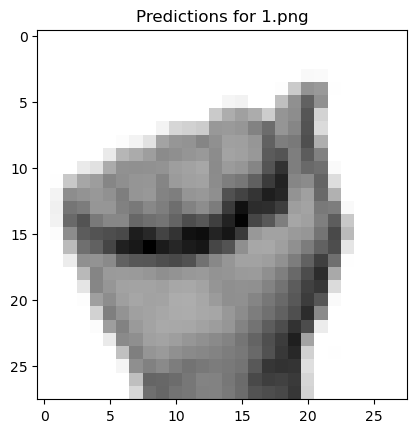

1/1 [==============================] - 0s 11ms/step
Predictions for 2.png:
Prediction: A, Confidence: 0.0007030075)
Prediction: B, Confidence: 0.0002604297)
Prediction: C, Confidence: 0.9883583188)
Prediction: D, Confidence: 0.0000287561)
Prediction: E, Confidence: 0.0001540366)
Prediction: F, Confidence: 0.0000196693)
Prediction: G, Confidence: 0.0001002501)
Prediction: H, Confidence: 0.0000914881)
Prediction: I, Confidence: 0.0000066651)
Prediction: K, Confidence: 0.0003677278)
Prediction: L, Confidence: 0.0000039052)
Prediction: M, Confidence: 0.0000484703)
Prediction: N, Confidence: 0.0020718647)
Prediction: O, Confidence: 0.0067351088)
Prediction: P, Confidence: 0.0000415452)
Prediction: Q, Confidence: 0.0007793920)
Prediction: R, Confidence: 0.0000001261)
Prediction: S, Confidence: 0.0000027640)
Prediction: T, Confidence: 0.0000008124)
Prediction: U, Confidence: 0.0000090673)
Prediction: V, Confidence: 0.0000000006)
Prediction: W, Confidence: 0.0000002360)
Prediction: X, Confiden

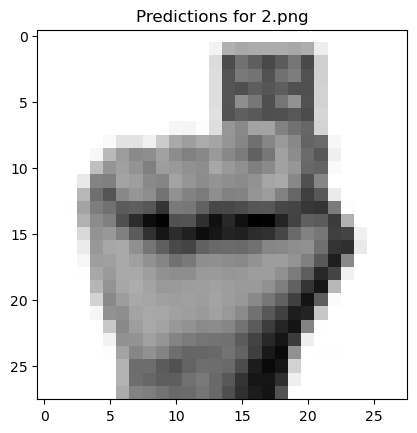

1/1 [==============================] - 0s 10ms/step
Predictions for 3.png:
Prediction: A, Confidence: 0.0000000017)
Prediction: B, Confidence: 0.0000000000)
Prediction: C, Confidence: 0.0000000329)
Prediction: D, Confidence: 0.0001600322)
Prediction: E, Confidence: 0.0000000000)
Prediction: F, Confidence: 0.0000000072)
Prediction: G, Confidence: 0.0000000002)
Prediction: H, Confidence: 0.0000002592)
Prediction: I, Confidence: 0.0000664980)
Prediction: K, Confidence: 0.0000000281)
Prediction: L, Confidence: 0.9994693398)
Prediction: M, Confidence: 0.0000000010)
Prediction: N, Confidence: 0.0000000016)
Prediction: O, Confidence: 0.0000000000)
Prediction: P, Confidence: 0.0000000000)
Prediction: Q, Confidence: 0.0000000000)
Prediction: R, Confidence: 0.0000001128)
Prediction: S, Confidence: 0.0000000076)
Prediction: T, Confidence: 0.0002597722)
Prediction: U, Confidence: 0.0000000000)
Prediction: V, Confidence: 0.0000049396)
Prediction: W, Confidence: 0.0000000000)
Prediction: X, Confiden

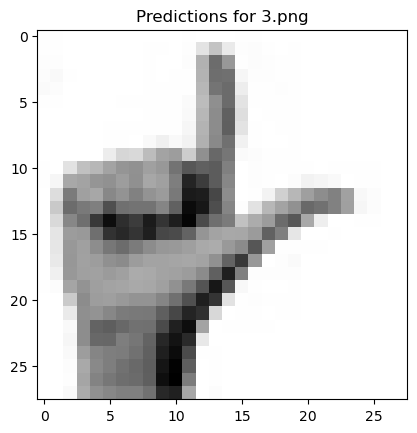

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the provided images
image_paths = [
    "1.png",
    "2.png",
    "3.png"
]

for image_path in image_paths:
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_resized = image.resize((28, 28))
    image_array = np.array(image_resized) / 255.0
    image_input = image_array.reshape(1, 28, 28, 1)

    # Make prediction using the loaded model
    prediction = model.predict(image_input)
    predarray = np.array(prediction[0])
    letterpred = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
    predictions = {letterpred[i]: float(predarray[i]) for i in range(len(letterpred))}

    # Print predictions with confidence scores
    print(f"Predictions for {image_path}:")
    for letter, confidence in predictions.items():
        number = confidence
        print(f"Prediction: {letter}, Confidence: {number:.10f})")

    # Display the image
    plt.imshow(image_array, cmap='gray')
    plt.title(f"Predictions for {image_path}")
    plt.show()